<a href="https://colab.research.google.com/github/akashsky1994/data-science-projects/blob/main/hotel_yearly_availability_prediction/hotel_yearly_availability_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Challenge

In [ ]:
# To install packages that are not installed by default, uncomment the last two lines 
# of this cell and replace <package list> with a list of necessary packages.
# This will ensure the notebook has all the dependencies and works everywhere.

import sys
!{sys.executable} -m pip install scikit-learn

In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 101)

## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

## Data Wrangling & Visualization

In [ ]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [ ]:
data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1


In [ ]:
#Explore columns
data.columns

Index(['id', 'region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id',
       'owned_hotels', 'yearly_availability'],
      dtype='object')

In [ ]:
#Description
data.describe()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
count,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2194.000000,2.870000e+03,2870.000000,2870.000000
mean,26760.657143,40.731224,-73.950158,195.943206,11.530314,16.315331,1.157502,7.202195e+07,8.411498,0.498606
std,14140.930062,0.054942,0.049745,406.184714,37.972339,32.481722,1.355028,8.076516e+07,27.105522,0.500085
min,0.000000,40.507080,-74.242850,10.000000,1.000000,0.000000,0.010000,2.787000e+03,1.000000,0.000000
25%,15931.750000,40.692463,-73.984003,75.000000,1.000000,1.000000,0.240000,7.388002e+06,1.000000,0.000000
50%,28946.500000,40.728250,-73.956720,120.000000,3.000000,4.000000,0.650000,3.352708e+07,1.000000,0.000000
75%,38478.500000,40.762658,-73.934202,200.000000,6.000000,16.000000,1.530000,1.207625e+08,3.000000,1.000000
max,48893.000000,40.898730,-73.721730,9999.000000,999.000000,395.000000,10.370000,2.738123e+08,327.000000,1.000000


## Data Wrangling

One Hot Encoding

In [ ]:
data['region'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

In [ ]:
data['accommodation_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [ ]:
# One Hot Encoding to generate necessary columns for each region since the region is a categorical data 
# Also since we have are seeing a limited number of places shown in the training and testing 
# i.e 5 boroughs of new york therefore it makes sense to do one hot encoding if there were too many regions
# this would not worked as it would complicate the model 
data = pd.concat([data,pd.get_dummies(data['region'], prefix='region')],axis=1)



# similarly for accomodation_type doing one hot encoding and adding the types as column
data = pd.concat([data,pd.get_dummies(data['accommodation_type'])],axis=1)

# dropping the region columns from the dataframe
data.drop(['region','accommodation_type'],axis=1, inplace=True)

In [ ]:
# we can go ahead and remove id from the dataframe to anonymize the data and secondly we dont really
# require the owner_id or id in the model itself
data.drop(['id','owner_id'],axis=1, inplace=True)

In [ ]:
# Checking for columns with null values
data.isnull().any()

latitude                False
longitude               False
cost                    False
minimum_nights          False
number_of_reviews       False
reviews_per_month        True
owned_hotels            False
yearly_availability     False
region_Bronx            False
region_Brooklyn         False
region_Manhattan        False
region_Queens           False
region_Staten Island    False
Entire home/apt         False
Private room            False
Shared room             False
dtype: bool

#### Found reviews_per_month to only have null values. Now filling the null values with median. (Mean is quite sensitive outliers specially incases with review/ratings hence using median)

In [ ]:
# filling na values
data['reviews_per_month'].fillna(data['reviews_per_month'].median(),inplace=True)

#### Geo Coordinates Column cannot be used as it is. Neither can they be ideally represented using stardardization. Clustering these geolocations into zones can help us get some relevant features.


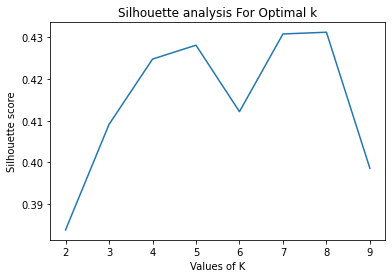

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = np.arange(2,10)
silhouette_avg = []
data_f = data.loc[:,['longitude','latitude']]
for num_clusters in range_n_clusters:

  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(data_f)
  cluster_labels = kmeans.labels_

  # silhouette score
  silhouette_avg.append(silhouette_score(data_f, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()


In [ ]:
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg)]
print("optimal_n_clusters",optimal_n_clusters)

optimal_n_clusters 8


In [ ]:
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
kmeans.fit(data_f)
geoLoc=kmeans.labels_
geoLoc.shape

(2870,)

In [ ]:
data['zone'] = geoLoc.tolist()

In [ ]:
data = pd.concat([data,pd.get_dummies(data['zone'],prefix='zone')],axis=1)

# dropping the region columns from the dataframe
data.drop(['latitude','longitude','zone'],axis=1, inplace=True)

In [ ]:
# output
Y = data['yearly_availability']
# input features variable
X = data.loc[:, data.columns != 'yearly_availability']

## Visualization, Modeling, Machine Learning

Build a model that categorizes hotels on the basis of their yearly availability.  Identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of Accuracy.**
- **Read the test.csv file and prepare features for testing.**

In [ ]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,NaN,13773574,12
3,33694,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,28873,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2


#### Implementing same set of data processing as done in training set

In [ ]:
geo_data_test = test_data.loc[:,['longitude','latitude']]
geo_labels_test = kmeans.predict(geo_data_test)
test_data['zone'] = geo_labels_test.tolist()
test_data = pd.concat([test_data,pd.get_dummies(test_data['zone'],prefix='zone')],axis=1)
test_data.drop(['latitude','longitude','zone'],axis=1, inplace=True)

In [ ]:
test_data = pd.concat([test_data,pd.get_dummies(test_data['region'], prefix='region')],axis=1)
test_data = pd.concat([test_data,pd.get_dummies(test_data['accommodation_type'])],axis=1)

# since we have model by filling nan value with training data we have to fill nan value in testing data with the median of training data
test_data['reviews_per_month'].fillna(X['reviews_per_month'].median(),inplace=True)
X_test = test_data.drop(['id','owner_id','region','accommodation_type'],axis=1)

Standardizing the data for better modeling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Adding Cross Validation Module
from sklearn.model_selection import cross_val_score, cross_validate


In [ ]:
# Standardizing training data
sc = StandardScaler()
sc.fit(X)
X_transformed=sc.transform(X)

In [ ]:
# Standardizing testing data with respect to training data
X_test = sc.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


#### Now we will be trying multiple classification techniques and select the most optimal model

In [ ]:
# loading Logistic Regression Model for classification
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
print(cross_val_score(estimator=clf, X=X_transformed, y=Y, cv=7, n_jobs=4).mean())

0.8738675958188153


In [ ]:
# Using Support Vector Classifier (SVC) with kernels [linear,rbf, polynomial]
from sklearn.svm import SVC

# iterating over each kernel
kernels = ['linear','rbf','poly']
for kernel in kernels:
    clf=SVC(kernel=kernel)
    print(kernel,cross_val_score(estimator=clf, X=X_transformed, y=Y, cv=7, n_jobs=4).mean())

linear 0.8477351916376307
rbf 0.8787456445993032
poly 0.8717770034843205


In [ ]:
# Using K Nearest neighbour technique
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

scores = {}
scores_list = []
for k in range(1,15):
   clf = KNeighborsClassifier(n_neighbors=k)
   print("for k=",k,":",cross_val_score(estimator=clf, X=X_transformed, y=Y, cv=7, n_jobs=4).mean())

for k= 1 : 0.870034843205575
for k= 2 : 0.8515679442508711
for k= 3 : 0.8853658536585367
for k= 4 : 0.8811846689895472
for k= 5 : 0.8926829268292683
for k= 6 : 0.8811846689895472
for k= 7 : 0.8857142857142858
for k= 8 : 0.8787456445993032
for k= 9 : 0.8874564459930313
for k= 10 : 0.8822299651567944
for k= 11 : 0.8853658536585367
for k= 12 : 0.8777003484320558
for k= 13 : 0.8794425087108014
for k= 14 : 0.8763066202090591


In [ ]:
# Using Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()
print(cross_val_score(estimator=clf, X=X_transformed, y=Y, cv=7, n_jobs=4).mean())

0.932404181184669


Now since we can see that Random Forest Classifier has the highest accuracy among all the classification techniques used. Hence we will go with this one.



**Highlight the most important features of the model for management.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


In [ ]:
clf.fit(X_transformed,Y)
importances = clf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_indices

array([11, 10,  4,  3,  2,  0,  1, 12, 19, 15,  7,  8, 14, 18,  6,  5, 17,
       13, 16, 20,  9])

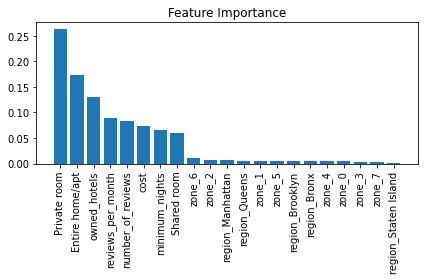

In [ ]:
import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `yearly_availability` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **yearly_availability**

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred.shape

(718,)

In [ ]:
submission_df = pd.DataFrame(columns=['id','yearly_availability'])
submission_df['id'] = test_data['id']
submission_df['yearly_availability'] = np.array(y_pred).tolist()

In [ ]:
submission_df.head()

,id,yearly_availability
0,19215,0
1,36301,0
2,40566,1
3,33694,0
4,28873,0


In [ ]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---